In this notebook GoogLeNet (Szegedy C., et. al. “Going Deeper with Convolutions”) is recreated but for the sake of disk space and computational time it is runned on Flowers data set. GoogLeNet consists of inception modules (several parallel convulation layers that are concatenated) and auxiliary outputs that are weighted and used for training to address the vanishing gradient problem. Architecture is build using high-level keras API, with inheritance of tf.keras.layers.Layer and tf.keras.Model. 
### Import libraries

In [1]:
import tensorflow as tf 

tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

### Load dataset
Load the data set and define basic data set preprocessing and sampling options.

In [3]:
dataset_name = 'tf_flowers'
batch_size = 32

@tf.function
def transform_inp(image, label):
  image = tf.image.resize_with_crop_or_pad(image, 227, 227)
  #image = crop_center(image)
  return tf.cast(image, tf.float32)/255., tf.one_hot(label, depth=5)

train_ds = tfds.load(dataset_name, split='train[:-20%]', as_supervised=True)
valid_ds = tfds.load(dataset_name, split='train[-20%:-10%]', as_supervised=True)
test_ds = tfds.load(dataset_name, split='train[-10%:]', as_supervised=True)

train_ds = train_ds.map(transform_inp).shuffle(1024).batch(batch_size)
valid_ds = valid_ds.map(transform_inp).shuffle(1024).batch(batch_size)
test_ds = test_ds.map(transform_inp).shuffle(1024).batch(batch_size)

### Model
We define our model following AlexNet architecture.

In [4]:
#First two building blocks/layers
#Inception Module
class InceptionModule(tf.keras.layers.Layer):
    def __init__(self, f_1x1, f_3x3_r, f_3x3,
                f_5x5_r, f_5x5, f_pool):
        super(InceptionModule, self).__init__(name='')
        #first branch
        self.conv_1x1 = tf.keras.layers.Conv2D(f_1x1, (1, 1), padding='same',
                    activation='relu')
        #second branch
        self.conv_3x3_a = tf.keras.layers.Conv2D(f_3x3_r, (1, 1), padding='same',
                    activation='relu')
        self.conv_3x3_b = tf.keras.layers.Conv2D(f_3x3, (3, 3), padding='same',
                    activation='relu')
        #third branch
        self.conv_5x5_a = tf.keras.layers.Conv2D(f_5x5_r, (1, 1), padding='same', 
                    activation='relu')
        self.conv_5x5_b = tf.keras.layers.Conv2D(f_5x5, (5, 5), padding='same', 
                    activation='relu')
        #fourth branch
        self.pool_proj_a = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')
        self.pool_proj_b = tf.keras.layers.Conv2D(f_pool, (1, 1), padding='same',
                    activation='relu')

    def call(self, x):
        #first branch
        b1 = self.conv_1x1(x)
        #second branch
        b2 = self.conv_3x3_a(x)
        b2 = self.conv_3x3_b(b2)
        #third branch
        b3 = self.conv_5x5_a(x)
        b3 = self.conv_5x5_b(b3)
        #fourth branch
        b4 = self.pool_proj_a(x)
        b4 = self.pool_proj_b(b4)
        #output (branches joined)
        output = tf.concat([b1, b2, b3, b4], axis=3)
        return output

#Inception Module
class AuxiliaryOutput(tf.keras.layers.Layer):
    def __init__(self, num_classes):
        super(AuxiliaryOutput, self).__init__(name='')
        self.pool = tf.keras.layers.AveragePooling2D([5, 5], strides = 3)
        self.conv_1x1 = tf.keras.layers.Conv2D(128, [1, 1])
        self.flat = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(1024, activation='relu')  
        self.drop = tf.keras.layers.Dropout(0.5)
        self.dense_2 = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.pool(x)
        x = self.conv_1x1(x)
        x = self.flat(x)
        x = self.dense_1(x)
        x = self.drop(x)
        x = self.dense_2(x)
        out = tf.nn.softmax(x)  
        return out


class GoogLeNet(tf.keras.Model):
  def __init__(self, num_classes):
    super(GoogLeNet, self).__init__(name='')
    #initial data convulation/pooling  
    self.conv_7x7_1 = tf.keras.layers.Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')
    self.pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')    
    self.conv2_3x3_red = tf.keras.layers.Conv2D(64, (1,1), padding='same', activation='relu')
    self.conv2_3x3 = tf.keras.layers.Conv2D(192, (3,3), padding='same', activation='relu')
    self.pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')
    #inceptions        
    self.inception_1 = InceptionModule(64, 96, 128, 16, 32, 32)
    self.inception_2 = InceptionModule(128, 128, 192, 32, 96, 64)
    self.inception_3 = InceptionModule(192, 96, 208, 16, 48, 64)
    self.out_1 = AuxiliaryOutput(num_classes)
    self.inception_4 = InceptionModule(160, 112, 224, 24, 64, 64)
    self.inception_5 = InceptionModule(128, 128, 256, 24, 64, 64)
    self.inception_6 = InceptionModule(112, 144, 288, 32, 64, 64)                        
    self.out_2 = AuxiliaryOutput(num_classes)
    self.inception_7 = InceptionModule(256, 160, 320, 32, 128, 128)
    self.inception_8 = InceptionModule(256, 160, 320, 32, 128, 128)
    self.inception_9 = InceptionModule(384, 192, 384, 48, 128, 128)
    #final data handling
    self.pool_3 = tf.keras.layers.AveragePooling2D(pool_size=(7,7), strides=(1,1))
    self.flat = tf.keras.layers.Flatten()
    self.drop_1 = tf.keras.layers.Dropout(rate=0.4)
    self.dens_1 = tf.keras.layers.Dense(num_classes, activation='softmax')

  def call(self, x, training=False):
    x = self.conv_7x7_1(x)
    x = self.pool_1(x)
    x = self.conv2_3x3_red(x)                      
    x = self.conv2_3x3(x)
    x = self.pool_2(x)
    x = self.inception_1(x)
    x = self.inception_2(x)
    x = self.inception_3(x)
    if training:
        o1 = self.out_1(x)
    x = self.inception_4(x)
    x = self.inception_5(x)
    x = self.inception_6(x)                                  
    if training:
        o2 = self.out_2(x)
    x = self.inception_7(x)
    x = self.inception_8(x)
    x = self.inception_9(x)
    x = self.pool_3(x)
    x = self.flat(x)
    x = self.drop_1(x)                                   
    o3 = self.dens_1(x)                                  
    if training:
        o1 = tf.math.multiply(o1, 0.3)
        o2 = tf.math.multiply(o2, 0.3)
        o = tf.math.add(o1, o2)
        o = tf.math.add(o, o3)   
        return o
    else:
        return o3

model = GoogLeNet(5)

Let's check the model summary.

### Defining the loss function and compiling the model

Here we define our optimizer, loss function, and necessary metrics.

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])

### Plotting function
We define plotting function to investigate training of our model

In [6]:
def plot_conv(hist):                     
    history_dict = hist.history
    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    epochs = range(1, len(train_acc) + 1)
    axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[0].plot(epochs, train_loss, c='orange', label='Training loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    #axs[0].set_xscale('log')
    axs[0].legend()
    
    axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
    axs[1].plot(epochs, train_acc, c='orange', label='Training accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    #axs[1].set_xscale('log')
    axs[1].legend()
    plt.tight_layout()

    print("Final statistics")
    print("Training")
    print("Loss: {:.3f}  Accuracy: {:.3f}".format(train_loss[-1], train_acc[-1]))
    print("Validation")
    print("Loss: {:.3f}  Accuracy: {:.3f}".format(val_loss[-1], val_acc[-1]))

### Training

We train our model for 10 epochs to see how it performs.

Epoch 1/20
92/92 [==============================] - 62s 581ms/step - loss: 1.6034 - accuracy: 0.2541 - val_loss: 1.6258 - val_accuracy: 0.1608
Epoch 2/20
92/92 [==============================] - 49s 524ms/step - loss: 1.6008 - accuracy: 0.2353 - val_loss: 1.5368 - val_accuracy: 0.3270
Epoch 3/20
92/92 [==============================] - 49s 528ms/step - loss: 1.5595 - accuracy: 0.2672 - val_loss: 1.7981 - val_accuracy: 0.3488
Epoch 4/20
92/92 [==============================] - 49s 529ms/step - loss: 1.4015 - accuracy: 0.3936 - val_loss: 1.6584 - val_accuracy: 0.5068
Epoch 5/20
92/92 [==============================] - 49s 529ms/step - loss: 1.3136 - accuracy: 0.4244 - val_loss: 1.2745 - val_accuracy: 0.5150
Epoch 6/20
92/92 [==============================] - 50s 531ms/step - loss: 1.2278 - accuracy: 0.4880 - val_loss: 1.6988 - val_accuracy: 0.5722
Epoch 7/20
92/92 [==============================] - 50s 531ms/step - loss: 1.1639 - accuracy: 0.5435 - val_loss: 1.5566 - val_accuracy: 0.5095

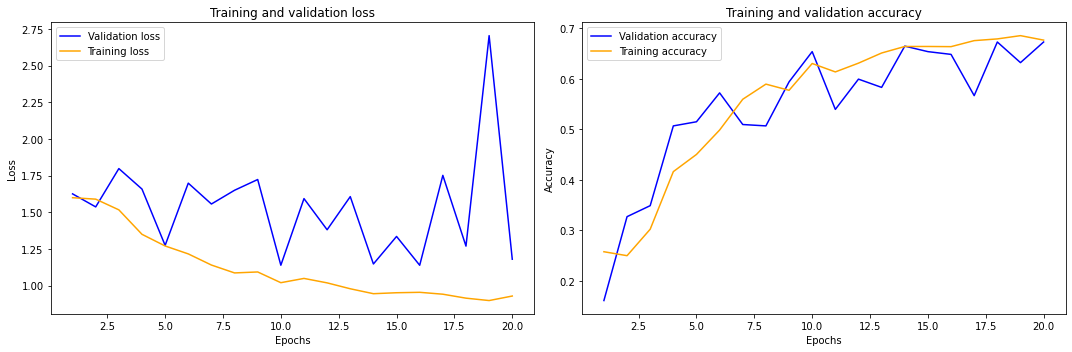

In [7]:
base_hist = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds, 
    verbose = 1
)

plot_conv(base_hist)

The implemented architecture works correctly. In 20 epochs over 67% of accuracy was achived and there is still some room for improvements. 